
# Scraping Fitreserve and Classpass Websites


The fitness industry is going through a moment of a lot of innovations, with new types of gyms and studios opening every day. With that, the fitness aggregators are changing the way people workout, giving more flexibility for User to try different modalities under a single membership. 

In the US, Classpass (“CP”) is the largest fitness aggregator, present in more than 40 cities and with a studio network of over 13,000 partners. However, new entrants – like FitReserve (“FR”) used in this analysis – might still have its share in this evolving market. 

As one of the key drivers for success of a fitness aggregator is the quality of the supply, this project aims to analyze the best strategy for FR’s supply growth, investigating CP network in US major cities


In [1]:
from pathlib import Path
import csv
import glob
import os
import fnmatch
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


### Classpass


In [2]:
filesClasspass = []
for file_name in os.listdir('.'):
    if fnmatch.fnmatch(file_name, 'classpass*.csv'):
        filesClasspass.append(file_name)
        
filesClasspass

['classpassAustin.csv',
 'classpassBoston.csv',
 'classpassChicago.csv',
 'classpassDallas.csv',
 'classpassHouston.csv',
 'classpassLosAngeles.csv',
 'classpassNY.csv',
 'classpassPhiladelphia.csv',
 'classpassPhoenix.csv',
 'classpassSanAntonio.csv',
 'classpassSanDiego.csv',
 'classpassSanJose.csv',
 'classpassWashingtonDC.csv']

In [3]:
dfsClasspass = []
for filename in filesClasspass:
    df = pd.read_csv(filename, header = None,
                 names = ["Activity", "Gym_name", "Address", "Rating", "Reviews"])
    df["Reviews"] = df["Reviews"].apply(lambda x: "(100-)" if "+" not in x else x)
    df["City"] = re.search('classpass(.*).csv', filename).group(1)
    df["Rating"] = pd.to_numeric(df.Rating)
    dfsClasspass.append(df)
    
dfsClasspass = pd.concat(dfsClasspass)
dfsClasspass.to_csv("CPMerged.csv")

In [4]:
dfsClasspass.sample(10)

,Activity,Gym_name,Address,Rating,Reviews,City
179,DANCE,Arthur Murray Phoenix,"1210 East Indian School Road, Phoenix",4.9,(100-),Phoenix
131,"GYM TIME, STRENGTH TRAINING",Wicker Park Fitness,"1735 W Division St #1, Chicago",4.7,(500+),Chicago
181,BOXING,Glitter & Gloves Fitness,"7830 E Redfield Rd, Ste 2/3, Scottsdale",4.5,(100-),Phoenix
157,CRYOTHERAPY,CryoEffect,"1967 North Halsted Street, Chicago",4.7,(500+),Chicago
570,STRENGTH TRAINING,Erin's Fitness Club,"150 Cypress Ave, Suite E, Burbank",4.9,(100+),LosAngeles
256,DANCE,Zumba with Megan,"Dance Center Chicago, 3868 N Lincoln Ave, Chicago",4.7,(100-),Chicago
360,MEDITATION,Chicago Meditation Space,"735 West 35th Street, Chicago",4.3,(100-),Chicago
288,DANCE,Mixfitz Studios,"3965 Belt Line Road, Addison",2.8,(100-),Dallas
285,YOGA,bode nyc,"143 W 72nd St, 1A, New York",4.7,(5000+),NY
321,BEAUTY,Stillness Holistic Spa,"2860 N Broadway #48, Chicago",5.0,(100-),Chicago


In [5]:
ClasspassCity = dfsClasspass.groupby(["City"], as_index=False)
CPCityCount = ClasspassCity.agg({"Gym_name": "count", "Rating": "mean"}).rename(columns={"Gym_name": "Number of Studios",
                                                                                        "Rating": "Avg Rating"})

CPorderstudio = CPCityCount.sort_values(by = "Number of Studios")["City"]
CPCityCount

,City,Number of Studios,Avg Rating
0,Austin,286,4.770629
1,Boston,325,4.777538
2,Chicago,373,4.773458
3,Dallas,289,4.749827
4,Houston,268,4.733209
5,LosAngeles,1018,4.775835
6,NY,1454,4.700413
7,Philadelphia,225,4.756889
8,Phoenix,224,4.817411
9,SanAntonio,64,4.735937


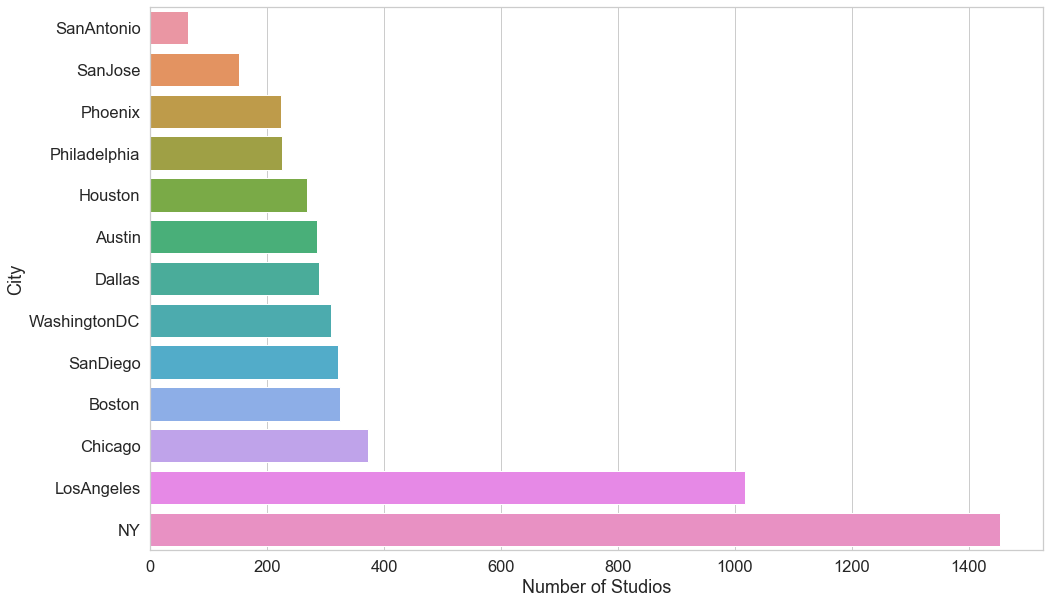

In [6]:
sns.set(style="whitegrid", font_scale = 1.5)
sns.diverging_palette(10, 220, sep=80, n=7)
plt.figure(figsize=(16, 10))
sns.barplot(y=CPCityCount['City'], x = CPCityCount["Number of Studios"], order = CPorderstudio)



NYC and LA are the top two markets for CP, followed by Chicago, and Boston. With that confirm that based on Supply sizing, FR is focused on the correct cities (as we will see below).  


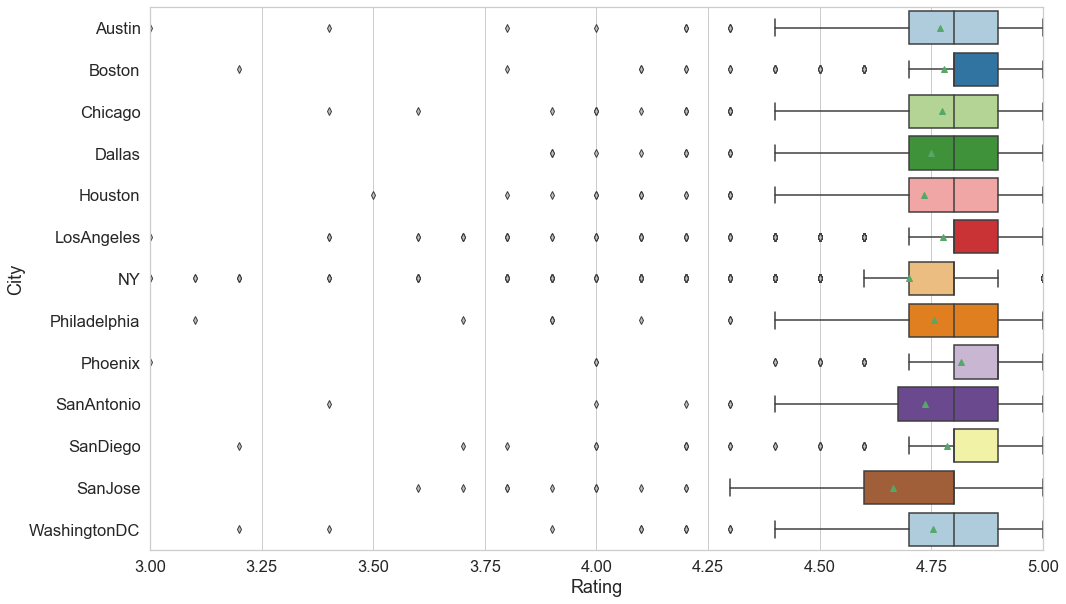

In [42]:
CPCityRating = dfsClasspass[["City", "Rating"]]
sns.set(style="whitegrid", font_scale = 1.5)
plt.figure(figsize=(16, 10))
plt.xlim(3, 5)
sns.boxplot(x = "Rating", y = "City", data = CPCityRating,
            palette="Paired",
            showmeans=True,
            flierprops=dict(markerfacecolor='0.75', markersize=5,linestyle='none'))



Aiming to spot a potential gap in the quality of the network, I also collected the average rating of each CP studio. 
Grouping the ratings per city, we see that there is some consistency in the quality, with all the cities with an avg. review above 4.7 – one potential gap, to be further explored, would be San Jose, which has the lowest avg rating.


In [8]:
CPCityReview = dfsClasspass.groupby(["City", "Reviews"], as_index=False).Gym_name.count()
CPCityReviewPivot = CPCityReview.pivot(index='Reviews', columns='City', values='Gym_name')


In [9]:
orderReview = ["(100-)", "(100+)", "(500+)", "(1000+)", "(5000+)"]
CPCityReviewPercent = ((100. * CPCityReviewPivot / CPCityReviewPivot.sum()).round(1)).T
CPCityReviewPercent = CPCityReviewPercent[orderReview]



Although the number of studios is an important metric, it doesn’t reflect the full market potential. To further investigate the demand for those studios, I got the number of reviews of each studio and used this as a proxy for demand.


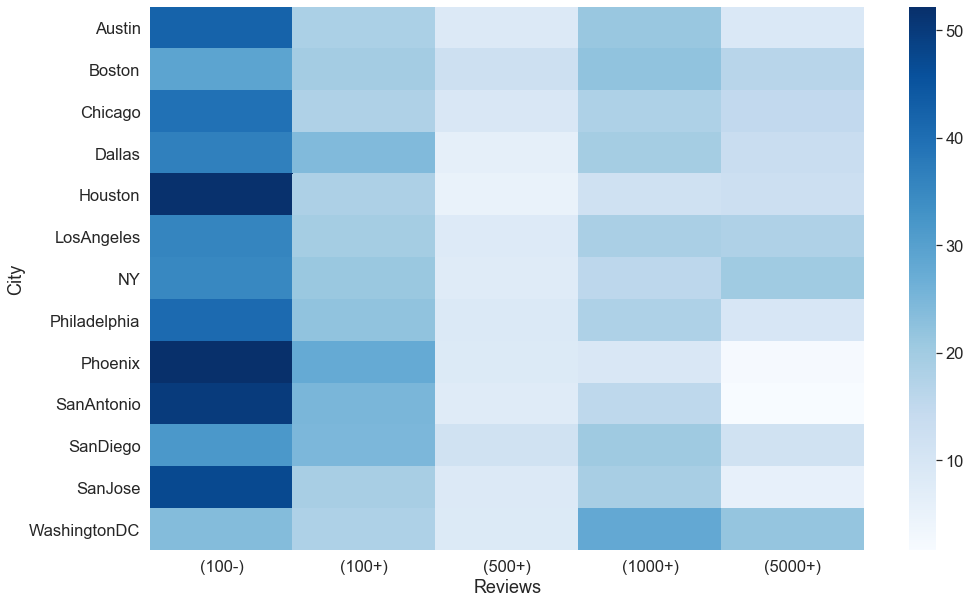

In [10]:
plt.figure(figsize=(16, 10))
sns.heatmap(data = CPCityReviewPercent, cmap = "Blues")


From the number of review analysis, we confirm that NYC, LA, Washington DC, and Boston are indeed the major markets where FR should continue to expand its network. If they decide to open new markets, the Tier 2 group should be Philadelphia, San Diego, and Austin. 


In [11]:
CPCityReviewStack = CPCityReviewPercent.stack().reset_index().rename(columns={0:'Percent'})



With thousands of studios to be targeted and added to the network, FR needs also to prioritize the type of studios to bring to the network.



In [12]:
CPAct = pd.DataFrame(dfsClasspass.Activity.str.split(',').tolist(), index=[dfsClasspass.Gym_name,
                                                                            dfsClasspass.Address,
                                                                            dfsClasspass.Rating,
                                                                            dfsClasspass.Reviews,
                                                                            dfsClasspass.City]).stack()
CPAct = CPAct.reset_index([0, 'Gym_name', 'Address', 'Rating', 'Reviews', 'City']).rename(columns={0:'Activity'})
CPAct = CPAct[CPAct.Activity != ' …']
CPAct['Activity'] = CPAct['Activity'].apply(lambda x: x.strip())
CPAct.sample(10)


,Gym_name,Address,Rating,Reviews,City,Activity
4121,Human@Ease,"31 Nassau Ave, Brooklyn",4.7,(500+),NY,STRENGTH TRAINING
3003,Anytime Fitness,"2217 Huntington Drive, Duarte",5.0,(100-),LosAngeles,GYM TIME
1568,Boost Pilates,"3339 W Lamar St, Houston",4.9,(5000+),Houston,PILATES
5230,Aqua Vida,"Penn’s Landing Marina, 301 S Christopher Colum...",4.8,(100-),Philadelphia,PILATES
3611,Pure Barre,"1681 Northern Blvd, Manhasset",4.8,(1000+),NY,BARRE
3534,Asana Soul Practice,"124 1st Street, Jersey City",4.8,(1000+),NY,YOGA
282,"Melanie Talbert, LMT","8015 Shoal Creek Blvd 110, Austin",4.9,(100-),Austin,MASSAGE
5044,Tuck Barre & Yoga,"3400 Lancaster Avenue Suite #6, Philadelphia",4.8,(500+),Philadelphia,YOGA
4055,Power Studios,"920 3rd Ave, 6th floor, New York",4.6,(5000+),NY,PILATES
6220,Next Phase Studio,"7610 Old Georgetown Rd, Bethesda",4.8,(5000+),WashingtonDC,STRENGTH TRAINING


In [36]:
ClasspassAct = CPAct.groupby(["Activity"], as_index=False)
CPActCount = ClasspassAct.agg({"Gym_name": "count", "Rating": "mean"}).rename(columns = {"Gym_name": "Number of Studios"})
CPActCount = CPActCount[CPActCount["Number of Studios"] > 50]

CPorderact = CPActCount.sort_values(by = "Number of Studios")["Activity"]

CPActCount

,Activity,Number of Studios,Rating
0,ACUPUNCTURE,65,4.801538
1,BARRE,347,4.799424
2,BEAUTY,154,4.666883
3,BOXING,293,4.792833
4,CRYOTHERAPY,78,4.762821
5,CYCLING,321,4.757321
6,DANCE,511,4.669080
7,FACIAL,125,4.688000
8,GYM TIME,245,4.695102
9,MARTIAL ARTS,186,4.739247


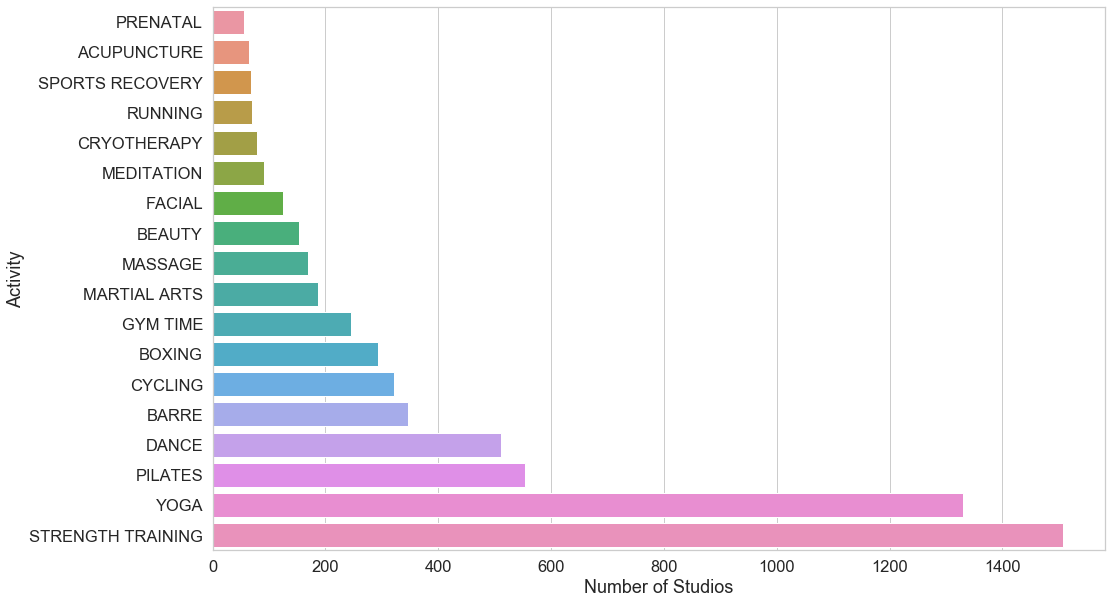

In [37]:
sns.set(style="whitegrid", font_scale = 1.5)
plt.figure(figsize=(16, 10))
sns.barplot(y = CPActCount['Activity'], x = CPActCount['Number of Studios'], order = CPorderact)


In this analysis, we see that CP (in these major cities) has a high concentration of Yoga and Strength Training type of Classes. 


In [15]:
Act = CPActCount.Activity.unique()
CPAct = CPAct[CPAct.Activity.isin(Act)]
ClasspassActS = CPAct.groupby(["Activity"], as_index=False)


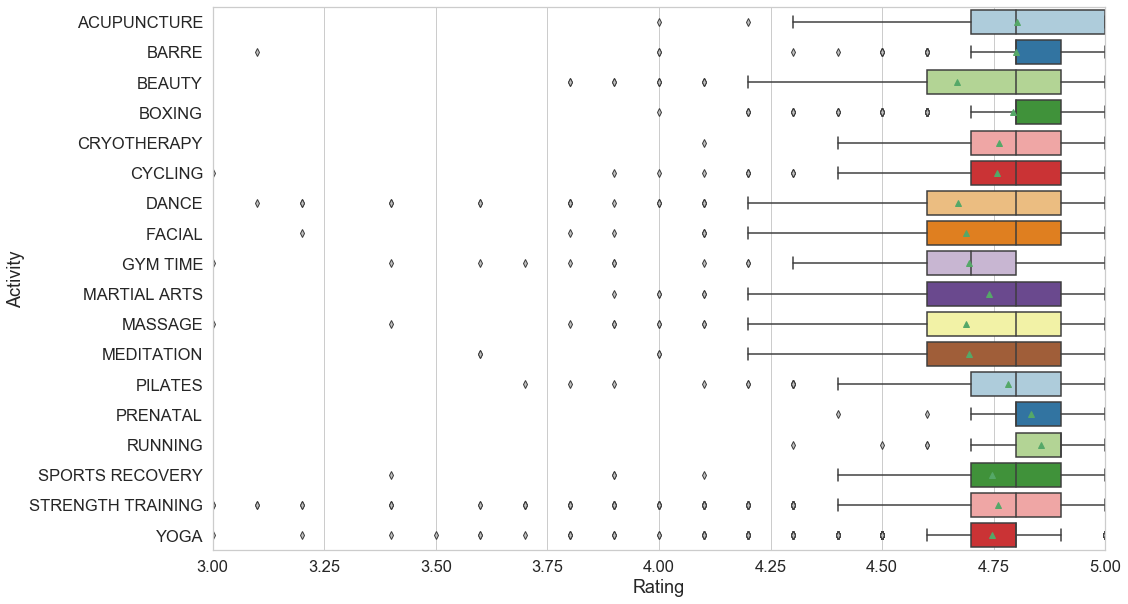

In [41]:
CPActRating = CPAct[["Activity", "Rating"]]
sns.set(style="whitegrid", font_scale = 1.5)
plt.figure(figsize=(16, 10))
plt.xlim(3, 5)
sns.boxplot(x = "Rating", y = "Activity", data = CPActRating,
            palette="Paired",
            showmeans=True,
            flierprops=dict(markerfacecolor='0.75', markersize=5,linestyle='none'),
            order = Act)




Analyzing the average rating per class type, we see that Boxing despite the lower number of reviews per Studio, should also be included in the FR prioritization as these Class types might make the User happier and more engaged with FR’s product.


In [17]:
CPActReview = CPAct.groupby(["Activity", "Reviews"], as_index=False).Gym_name.count()
CPActReviewPivot = CPActReview.pivot(index='Reviews', columns='Activity', values='Gym_name')

In [18]:
CPActReviewPercent = ((100. * CPActReviewPivot / CPActReviewPivot.sum()).round(1)).T
CPActReviewPercent = CPActReviewPercent[orderReview]
CPActReviewPercent

Reviews,(100-),(100+),(500+),(1000+),(5000+)
Activity,,,,,
ACUPUNCTURE,81.5,10.8,6.2,1.5,NaN
BARRE,8.6,19.3,8.6,32.9,30.5
BEAUTY,66.9,25.3,5.8,1.9,NaN
BOXING,34.5,25.9,8.2,16.7,14.7
CRYOTHERAPY,38.5,37.2,9.0,12.8,2.6
CYCLING,16.5,13.4,9.3,24.6,36.1
DANCE,48.7,24.7,8.8,12.7,5.1
FACIAL,69.6,20.8,4.8,4.0,0.8
GYM TIME,43.7,13.5,10.2,18.0,14.7


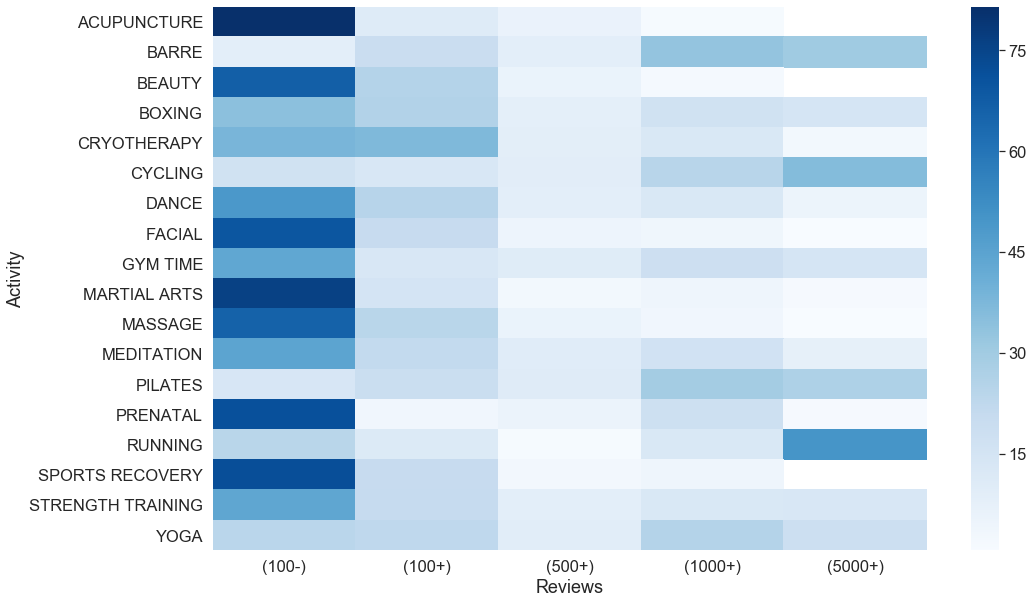

In [19]:
plt.figure(figsize=(16, 10))
sns.heatmap(data = CPActReviewPercent, cmap = "Blues")


Using the number of reviews per class type as a proxy for demand, I noticed that CP has a high volume of users going to Cycling, Pilates, and Barre. Therefore, FR when focusing it’s expansion, should aim to bring these types of studio to its network.


In [20]:
CPActReviewStack = CPActReviewPercent.stack().reset_index().rename(columns={0:'Percent'})


In [21]:
ClasspassCityAct = CPAct.groupby(["City", "Activity"], as_index = False).agg({"Gym_name": "count", "Rating": "mean"})
ClasspassCityActPivot = ClasspassCityAct.pivot(index='City', columns='Activity', values='Gym_name')
ClasspassCityActPivot = ClasspassCityActPivot.reset_index()
ClasspassCityActPivot.head()


Activity,City,ACUPUNCTURE,BARRE,BEAUTY,BOXING,CRYOTHERAPY,CYCLING,DANCE,FACIAL,GYM TIME,MARTIAL ARTS,MASSAGE,MEDITATION,PILATES,PRENATAL,RUNNING,SPORTS RECOVERY,STRENGTH TRAINING,YOGA
0,Austin,3.0,25.0,12.0,10.0,10.0,5.0,28.0,11.0,17.0,11.0,24.0,5.0,27.0,1.0,2.0,2.0,60.0,73.0
1,Boston,1.0,38.0,2.0,19.0,2.0,46.0,26.0,NaN,11.0,11.0,1.0,1.0,22.0,NaN,6.0,3.0,107.0,83.0
2,Chicago,NaN,23.0,30.0,19.0,8.0,18.0,27.0,17.0,12.0,14.0,12.0,7.0,34.0,5.0,10.0,3.0,111.0,97.0
3,Dallas,NaN,20.0,3.0,11.0,7.0,16.0,17.0,3.0,27.0,4.0,4.0,5.0,33.0,NaN,3.0,2.0,96.0,73.0
4,Houston,1.0,10.0,1.0,23.0,3.0,22.0,27.0,NaN,18.0,12.0,1.0,2.0,31.0,NaN,2.0,6.0,87.0,64.0


In [22]:
CPCAB = ClasspassCityActPivot.fillna(0).set_index("City")
CPCAB.loc[:,'Total'] = CPCAB.sum(axis=1)
CPCAB = CPCAB.iloc[:,0:19].div(CPCAB["Total"], axis = 0).reset_index()



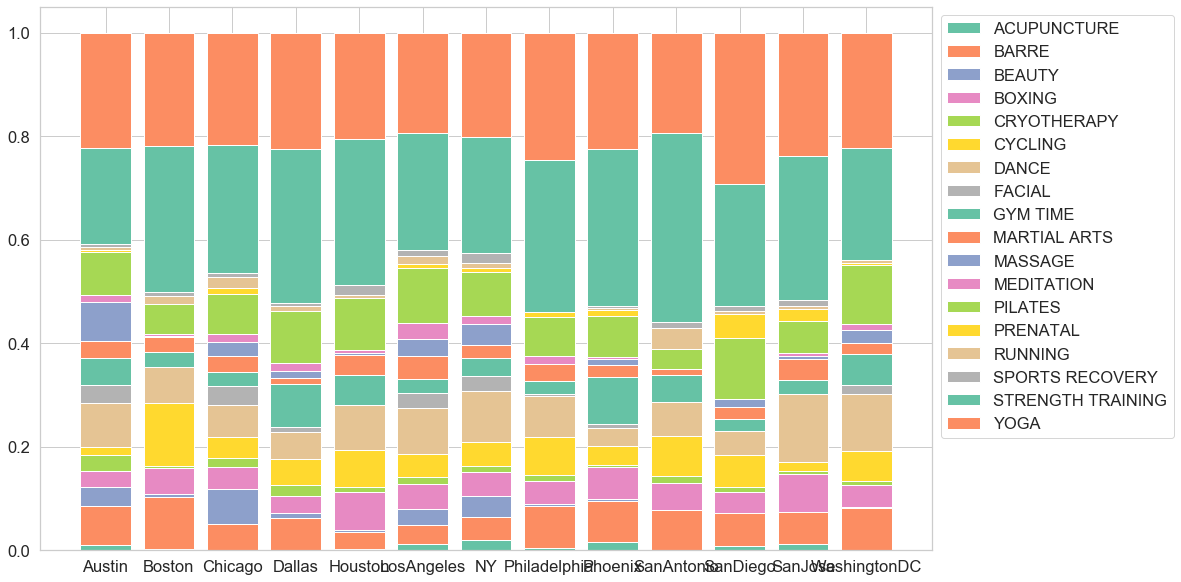

In [23]:
actlist = CPCAB.columns.tolist()
actlist = actlist[1:len(actlist)-1]
actlist_1 = ["Zero"] + actlist[0:len(actlist)]


r = CPCAB["City"]
bars = CPCAB.fillna(0)
bars = bars.rename(columns = {"City": "Zero"})
bars["Zero"] = np.zeros(13)

color = sns.color_palette(sns.color_palette("Set2", len(actlist)))


for i in range(1, len(actlist_1)-1):
    bars[actlist_1[i + 1]] =  bars[actlist_1[i + 1]] + bars[actlist_1[i]]

fig, ax = plt.subplots(figsize=(16, 10))
for i in range(0, len(actlist)):
    p1 = plt.bar(r, CPCAB[actlist[i]], bottom = bars[actlist_1[i]], color= color[i],
                 edgecolor='white', width=0.8, label = actlist[i])
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_facecolor('white')
plt.rc('legend', fontsize = 12)
plt.rc('axes', labelsize = 12)
plt.rc('xtick', labelsize = 12)
plt.show()




### FitReserve




In [24]:
fitreserve = pd.read_csv("fitreserve.csv", header = None,
                 names = ["Gym_name", "Address", "City", "State", "Zip"])

In [25]:
def f(row):
    if row['State'] == "NY":
        city = "NY"
    elif row['State'] == "IL":
        city = "Chicago"
    elif row['State'] == "CA":
        city = "LosAngeles"
    elif row['State'] == "DC":
        city = "WashingtonDC"
    elif row['State'] == "MA":
        city = "Boston"
    else:
        city = "Other"
    return city


fitreserve["MCity"] = fitreserve.apply(f, axis = 1)
fitreserve.head()

,Gym_name,Address,City,State,Zip,MCity
0,30/60/90 Fitness,656 6th Ave,"New York,",NY,10011,NY
1,39th Avenue Dance and Fitness,38-12 30th St,"Long Island City,",NY,11101,NY
2,92Y - May Center,1395 Lexington Ave,"New York,",NY,10128,NY
3,Aerial Arts NYC,235 East 49th Street,"New York,",NY,10017,NY
4,Aerial Fitness and Natural Wellness Center,38 West Main Street,"Riverhead,",NY,11901,NY


In [26]:
FitCity = fitreserve.groupby(["MCity"], as_index=False)
FitCityCount = FitCity.agg({"Gym_name": "count"}).rename(columns = {'Gym_name': "Number of Studios"})
FitCityCount

,MCity,Number of Studios
0,Boston,76
1,Chicago,44
2,LosAngeles,52
3,NY,293
4,Other,98
5,WashingtonDC,48


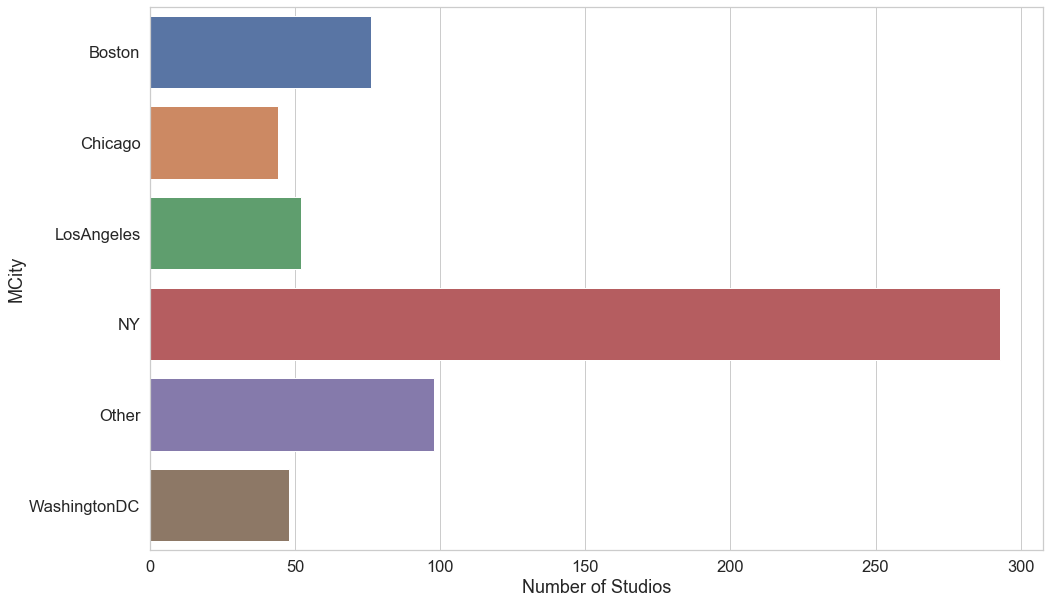

In [47]:
sns.set(style="whitegrid", font_scale = 1.5)
sns.diverging_palette(10, 220, sep = 80, n = 6)
plt.figure(figsize=(16, 10))
sns.barplot(y=FitCityCount['MCity'], x = FitCityCount['Number of Studios'])


In [28]:
CPNC = dfsClasspass[["Gym_name", "City"]]
CPNC.insert(0, 'Agg', 'Classpass')
FNC = fitreserve[["Gym_name", "MCity"]]
FNC.insert(0, 'Agg', 'Fitreserve')

CPFdf = pd.concat([CPNC, FNC.rename(columns = {"MCity": "City"})])
CPFdf = CPFdf[CPFdf.City.isin(["NY", "WashingtonDC", "Boston", "LosAngeles", "Chicago"])]
CPFdf = CPFdf.groupby(["City", "Agg"], as_index=False).Gym_name.count().rename(columns = {"Gym_name": "Number of Studios"})
CPFdf


,City,Agg,Number of Studios
0,Boston,Classpass,325
1,Boston,Fitreserve,76
2,Chicago,Classpass,373
3,Chicago,Fitreserve,44
4,LosAngeles,Classpass,1018
5,LosAngeles,Fitreserve,52
6,NY,Classpass,1454
7,NY,Fitreserve,293
8,WashingtonDC,Classpass,310
9,WashingtonDC,Fitreserve,48


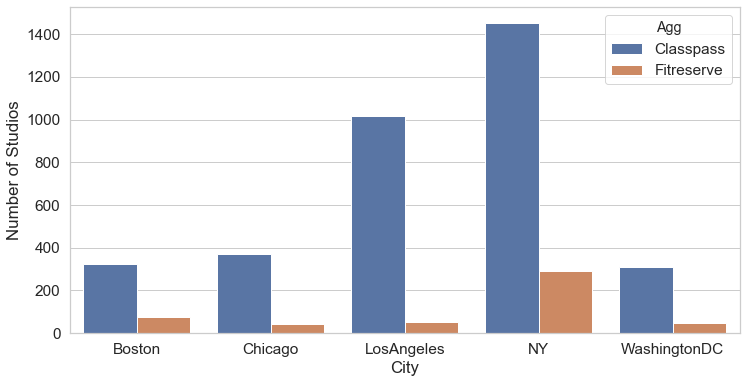

In [29]:
sns.set(style="whitegrid", font_scale = 1.4)
plt.figure(figsize=(12, 6))
sns.barplot(x = "City", y = "Number of Studios", hue = "Agg", data = CPFdf)


In [30]:
pal = sns.diverging_palette(10, 220, sep=80, n=7)
pal.as_hex()

['#da3b46', '#ea8f96', '#fae6e8', '#f2f2f2', '#eaf3f5', '#93b8c3', '#3f7f93']

In [31]:
pd.options.mode.chained_assignment = None
result = CPAct[CPAct.City.isin(["WashingtonDC", "NY", "LosAngeles", "Boston"]) &
               CPAct.Activity.isin(["RUNNING", "CYCLING", "BARRE", "PILATES"])]

result.sample(10)

,Gym_name,Address,Rating,Reviews,City,Activity
1976,Barry's Bootcamp,"700-B Allied Way, Suite B5.02, El Segundo",4.9,(1000+),LosAngeles,RUNNING
2147,Studio Pilates,"209 W Grand Ave, El Segundo",4.9,(1000+),LosAngeles,PILATES
2424,FIT4MOM,"13196 Bluff Creek Dr, Los Angeles",4.9,(100+),LosAngeles,BARRE
3186,barre3,"63 W 8th St, 2nd floor, New York",4.8,(5000+),NY,BARRE
3330,SHAKTIBARRE,"2272 Adam Clayton Powell Junior Boulevard, Harlem",4.9,(1000+),NY,BARRE
4610,"[FREE] The Most Informal Running Club, Ever","Union Square JackRabbit, 42 W 14th St, New York",4.9,(100-),NY,RUNNING
3719,Juma Fit,"38 Franklin Street, Tenafly",5.0,(100+),NY,RUNNING
4707,BodyLine Pilates,"1361 Hylan Blvd, Staten Island",4.6,(100-),NY,PILATES
598,Yoga Nova,"51 Great Road, Bedford",4.9,(100+),Boston,PILATES
3734,Park Fitness BK,"771 Coney Island Ave, 2nd Floor, Brooklyn",4.8,(1000+),NY,CYCLING


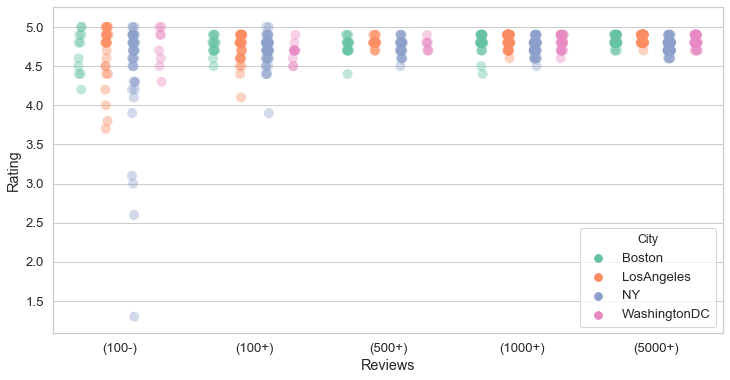

In [32]:
sns.set(style="whitegrid", font_scale = 1.2) 
plt.figure(figsize=(12, 6))
sns.stripplot(x = "Reviews", y = "Rating", data = result, hue ='City', jitter=0.05, palette="Set2", dodge = True,
             order = orderReview, alpha=.4, size = 10)



To help FR team prioritize which studios to bring to the network first, this analysis combines the rating and the number of reviews of CP studios focused on the most popular activites in the current FR’s cities. FR should start targeting the studios in the top-right corner.


With over 50 thousand gyms/studios in the USA, the success of FR’s network growth is highly dependent on how well it defines its lead scoring/prioritization strategy. Looking at CP current network (main competitor) and targeting its key studios can be a smart strategic move for FR, which allows it to have a better return in its marketing/personnel investment. 
As further investigation in the analysis, I would remove the overlapping FR/CP studios to have a clearer view of the networks. Finally, I would also get other sources of data (i.e. from YELP) to avoid being restrictive in targeting studios that are part of the CP network only.
